In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import sklearn
from sklearn.datasets import fetch_20newsgroups
import re

## Prepare the data

读取原始数据

In [2]:
cats = None

newsgroups_train_raw = fetch_20newsgroups(subset='train', categories=cats)

newsgroups_test_raw = fetch_20newsgroups(subset='test', categories=cats)

In [3]:
newsgroups_train_raw.data[1]

"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.\n\nGuy Kuo <guykuo@u.washington.edu>\n"

读取数据，去除新闻文档的标题、注脚和引用

In [4]:
cats = None

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats)

newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=cats)

In [5]:
newsgroups_train.data[1]

"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks."

In [6]:
newsgroups_train.filenames[1]

'/Users/fanfan/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51861'

文本预处理

In [7]:
def clean(text):
    """Remove posting header, split by sentences and words, keep only letters"""
    result = []
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    for line in lines:
        result = result + re.sub('[^a-zA-Z]', ' ', line).lower().split()
    return result

sentences = [clean(text) for text in newsgroups_train.data]

sentences_test = [clean(text) for text in newsgroups_test.data]

In [8]:
len(sentences)

11314

In [9]:
len(sentences_test)

7532

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from collections import Counter

对每个类别的文档数目进行统计

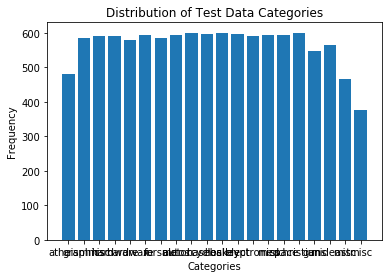

In [12]:
train_des = Counter(newsgroups_train.target)

plt.bar(list(train_des.keys()), list(train_des.values()), tick_label = [i.split('.')[-1] for i in newsgroups_train.target_names])
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Distribution of Test Data Categories')

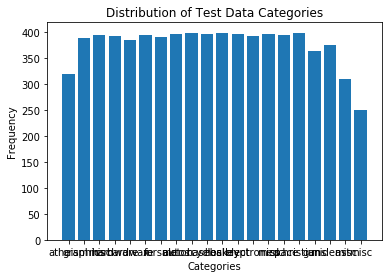

In [13]:
test_des = Counter(newsgroups_test.target)

plt.bar(list(test_des.keys()), list(test_des.values()), tick_label = [i.split('.')[-1] for i in newsgroups_test.target_names])
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Distribution of Test Data Categories')

对文档字数进行统计

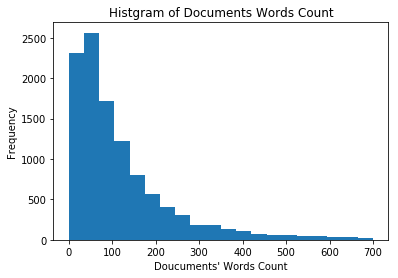

In [14]:
plt.hist([len(i) for i in sentences], range = (0,700), bins = 20)
plt.title('Histgram of Documents Words Count')
plt.xlabel("Doucuments' Words Count")
plt.ylabel('Frequency')

对词频进行统计

In [15]:
words = []
for sentence in sentences:
    words = words + sentence
count = Counter(words)

In [16]:
keys= [i[0] for i in count.most_common()]
values = [i[1] for i in count.most_common()]

In [17]:
len(count)

72904

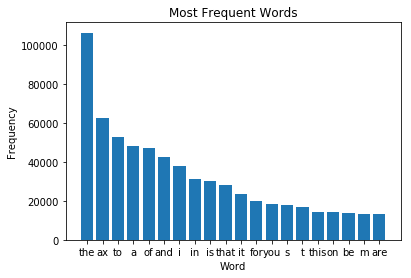

In [18]:
plt.bar(range(20), values[:20], tick_label =keys[:20])
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Frequent Words')

## Method 1: Bag of Words
### Preprocess the data with tf-idf

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vector_train = vectorizer.fit_transform(newsgroups_train.data)

vector_test = vectorizer.transform(newsgroups_test.data)

In [20]:
vector_train.shape

(11314, 101631)

### 定义函数用于训练和预测

In [21]:
def train_pred_fn(clf, train_data, test_data):
    clf.fit(train_data, newsgroups_train.target)
    print("Training score is %.3f"%clf.score(train_data, newsgroups_train.target))
    print("Testing score is %.3f"%clf.score(test_data, newsgroups_test.target))

### Classify with LogisticRegression

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

train_pred_fn(clf, vector_train, vector_test)

Training score is 0.896
Testing score is 0.678


### Classify with RandomForest

In [30]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

train_pred_fn(clf, vector_train, vector_test)

Training score is 0.971
Testing score is 0.396


### Classify with SVM

In [29]:
from sklearn.svm import SVC

clf = SVC(kernel = 'linear')

train_pred_fn(clf, vector_train, vector_test)

Training score is 0.954
Testing score is 0.663


### Tuning the hyperparameter

#### Logistic Regression

In [30]:
# 设置超参数范围
from sklearn.model_selection import GridSearchCV
parameters = {'C':[ 0.1, 1.0, 10.0, 50.0 ,100.0]}
clf = LogisticRegression()
# gridsearch
grid_obj = GridSearchCV(clf, param_grid = parameters, n_jobs = -1)
grid_obj.fit(vector_train, newsgroups_train.target)
# 最好的模型进行预测
best_clf = grid_obj.best_estimator_
print("Training score is %.3f"%best_clf.score(vector_train, newsgroups_train.target))
print("Testing score is %.3f"%best_clf.score(vector_test, newsgroups_test.target))

Training score is 0.975
Testing score is 0.685


In [31]:
best_clf

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
grid_obj.cv_results_

{'mean_fit_time': array([  7.79181767,  14.454609  ,  19.55138834,  24.30512174,  19.78922892]),
 'mean_score_time': array([ 0.03309703,  0.04240187,  0.03694431,  0.03882432,  0.01834242]),
 'mean_test_score': array([ 0.58714867,  0.70947499,  0.74005657,  0.74226622,  0.74270815]),
 'mean_train_score': array([ 0.7086365 ,  0.90516195,  0.9733075 ,  0.97472159,  0.97480995]),
 'param_C': masked_array(data = [0.1 1.0 10.0 50.0 100.0],
              mask = [False False False False False],
        fill_value = ?),
 'params': ({'C': 0.1}, {'C': 1.0}, {'C': 10.0}, {'C': 50.0}, {'C': 100.0}),
 'rank_test_score': array([5, 4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([ 0.58066225,  0.70251656,  0.73589404,  0.73509934,  0.73509934]),
 'split0_train_score': array([ 0.71375514,  0.90502719,  0.97453243,  0.97559358,  0.97559358]),
 'split1_test_score': array([ 0.59687252,  0.71746621,  0.74476544,  0.7490061 ,  0.74927114]),
 'split1_train_score': array([ 0.70587455,  0.90598064,  0.

In [33]:
grid_obj.cv_results_['params']

({'C': 0.1}, {'C': 1.0}, {'C': 10.0}, {'C': 50.0}, {'C': 100.0})

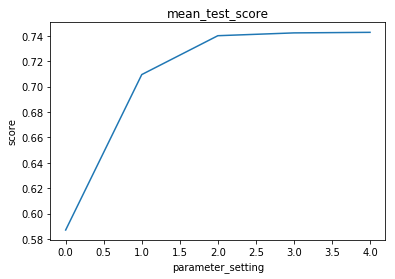

In [34]:
plt.plot(grid_obj.cv_results_['mean_test_score'])
plt.title('mean_test_score')
plt.xlabel('parameter_setting')
plt.ylabel('score')

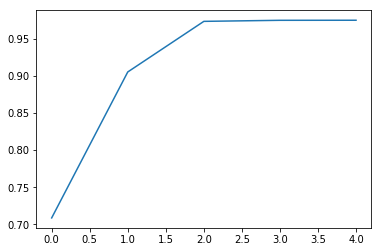

In [35]:
plt.plot(grid_obj.cv_results_['mean_train_score'])

#### SVM

In [44]:
# 设置超参数范围
parameters = {'C':[0.01, 0.1, 1, 10]}
clf = SVC(kernel = 'linear')
# gridsearch
grid_obj = GridSearchCV(clf, param_grid = parameters, n_jobs = -1)
grid_obj.fit(vector_train, newsgroups_train.target)
# 最好的模型进行预测
best_clf = grid_obj.best_estimator_
print("Training score is %.3f"%best_clf.score(vector_train, newsgroups_train.target))
print("Testing score is %.3f"%best_clf.score(vector_test, newsgroups_test.target))

Training score is 0.954
Testing score is 0.663


In [45]:
best_clf

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### RandomForest

In [31]:
# 设置超参数范围
parameters = {'n_estimators':[10, 100, 500],  'min_samples_split':[2,10,50]}
clf = RandomForestClassifier()
# gridsearch
grid_obj = GridSearchCV(clf, param_grid = parameters, n_jobs = -1)
grid_obj.fit(vector_train, newsgroups_train.target)
# 最好的模型进行预测
best_clf = grid_obj.best_estimator_
print("Training score is %.3f"%best_clf.score(vector_train, newsgroups_train.target))
print("Testing score is %.3f"%best_clf.score(vector_test, newsgroups_test.target))

Training score is 0.974
Testing score is 0.631


In [36]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [42]:
grid_obj.cv_results_

{'mean_fit_time': array([  17.84285132,  132.22401698,  567.95782669,    6.69344266,
          67.59419203,  305.81502207,    4.56150532,   43.75808994,
         227.78441191]),
 'mean_score_time': array([ 0.21424039,  1.25031734,  5.19717161,  0.09847975,  0.96242491,
         4.6964527 ,  0.08664441,  0.74543937,  3.38549272]),
 'mean_test_score': array([ 0.44166519,  0.62939721,  0.66095103,  0.49628779,  0.6459254 ,
         0.66572388,  0.52253845,  0.6465441 ,  0.66413293]),
 'mean_train_score': array([ 0.97180476,  0.97494254,  0.97494254,  0.9579289 ,  0.97445647,
         0.97454495,  0.88518529,  0.95638156,  0.95889994]),
 'param_min_samples_split': masked_array(data = [2 2 2 10 10 10 50 50 50],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [10 100 500 10 100 500 10 100 500],
              mask = [False False False False False False False False False],
        fill_value = ?),

In [40]:
grid_obj.cv_results_['params']

({'min_samples_split': 2, 'n_estimators': 10},
 {'min_samples_split': 2, 'n_estimators': 100},
 {'min_samples_split': 2, 'n_estimators': 500},
 {'min_samples_split': 10, 'n_estimators': 10},
 {'min_samples_split': 10, 'n_estimators': 100},
 {'min_samples_split': 10, 'n_estimators': 500},
 {'min_samples_split': 50, 'n_estimators': 10},
 {'min_samples_split': 50, 'n_estimators': 100},
 {'min_samples_split': 50, 'n_estimators': 500})

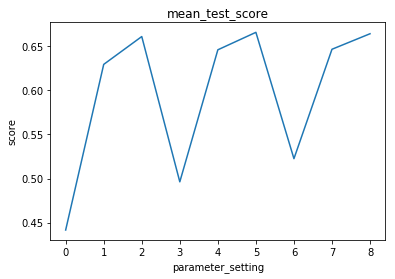

In [46]:
plt.plot(grid_obj.cv_results_['mean_test_score'])
plt.title('mean_test_score')
plt.xlabel('parameter_setting')
plt.ylabel('score')

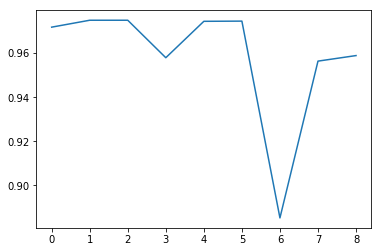

In [41]:
plt.plot(grid_obj.cv_results_['mean_train_score'])

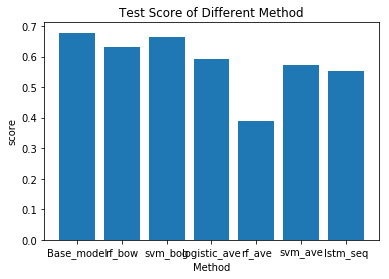

In [49]:
x = [0.678, 0.631, 0.663, 0.591, 0.390, 0.573, 0.553]
plt.bar(range(len(x)), x, tick_label =['Base_model', 'rf_bow','svm_bog','logistic_ave', 'rf_ave','svm_ave','lstm_seq'])
plt.xlabel('Method')
plt.ylabel('score')
plt.title('Test Score of Different Methods')

## Method 2: Word2Vec

In [55]:
# 使用gensim训练word2vec
dim = 100

model_news = gensim.models.Word2Vec(sentences, workers=4, size=dim, min_count=2, window=8, sample=1e-3, iter = 30000)

In [64]:
# 查看相似单词
model_news.most_similar("woman")

[('man', 0.6217696070671082),
 ('her', 0.5826433897018433),
 ('she', 0.5783253908157349),
 ('person', 0.534965991973877),
 ('dog', 0.5204246044158936),
 ('women', 0.5027643442153931),
 ('girl', 0.4961436688899994),
 ('mother', 0.4921339750289917),
 ('children', 0.45686399936676025),
 ('friend', 0.45095932483673096)]

In [86]:
model_news.most_similar("car")

[('bike', 0.7111523151397705),
 ('cars', 0.6475207805633545),
 ('engine', 0.5363672375679016),
 ('bikes', 0.5203389525413513),
 ('honda', 0.5200111865997314),
 ('tires', 0.5190979242324829),
 ('jacket', 0.5108001232147217),
 ('dealer', 0.5054090023040771),
 ('volvo', 0.4970071613788605),
 ('odometer', 0.49022600054740906)]

In [76]:
model_news.most_similar("mother")

[('father', 0.6114832162857056),
 ('wife', 0.5844025611877441),
 ('marina', 0.533140242099762),
 ('soul', 0.5187636017799377),
 ('neighbor', 0.5042768716812134),
 ('lord', 0.5013660788536072),
 ('son', 0.4962785243988037),
 ('woman', 0.4921340346336365),
 ('apartment', 0.4894893169403076),
 ('she', 0.4863095283508301)]

In [67]:
model_news.most_similar("man")

[('woman', 0.6217697262763977),
 ('person', 0.5439392924308777),
 ('god', 0.5286370515823364),
 ('he', 0.4848752021789551),
 ('jesus', 0.4779359698295593),
 ('himself', 0.47040891647338867),
 ('christ', 0.4632817506790161),
 ('angel', 0.45045924186706543),
 ('humankind', 0.44898122549057007),
 ('father', 0.44339221715927124)]

In [83]:
# 语义推断
model_news.wv.most_similar(positive=['dog', 'cat'], negative=['boy'])

[('person', 0.448219895362854),
 ('her', 0.42244499921798706),
 ('women', 0.41352951526641846),
 ('wast', 0.40973496437072754),
 ('she', 0.4056164026260376),
 ('tmu', 0.37912845611572266),
 ('whistle', 0.3739548325538635),
 ('strangers', 0.3730327785015106),
 ('agdam', 0.36491793394088745),
 ('walked', 0.36253565549850464)]

### convert document to vector

####  average the words' vector in each document

In [46]:
# 使用词向量平均进行文本表示
word2vec_train = np.zeros((len(sentences), dim))
for i, sentence in enumerate(sentences):
    count = 0.0
    for word in sentence:
        if word in model_news.wv.vocab:
            count += 1
            word2vec_train[i] += model_news[word]
    if count != 0:
        word2vec_train[i] = word2vec_train[i]/count
    
sentences_test = [clean(text) for text in newsgroups_test.data]
word2vec_test = np.zeros((len(sentences_test), dim))
for i, sentence in enumerate(sentences_test):
    count = 0
    for word in sentence:
        if word in model_news.wv.vocab:
            count += 1
            word2vec_test[i] += model_news[word]
    if count != 0:
        word2vec_test[i] = word2vec_test[i]/count

In [49]:
# 使用逻辑回归进行分类
clf = LogisticRegression()

train_pred_fn(clf, word2vec_train, word2vec_test)

Training score is 0.670
Testing score is 0.591


In [50]:
#使用随机森林进行分类
clf = RandomForestClassifier()

train_pred_fn(clf, word2vec_train, word2vec_test)

Training score is 0.970
Testing score is 0.390


In [51]:
#使用svm进行分类
clf = SVC(kernel = 'linear')

train_pred_fn(clf, word2vec_train, word2vec_test)

Training score is 0.750
Testing score is 0.573


### Use text8 to train skip-gram model

In [52]:
# 下载数据集
url = 'http://mattmahoney.net/dc/'
import os
from six.moves.urllib.request import urlretrieve

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [53]:
# 解压数据集
!unzip text8.zip

Archive:  text8.zip
  inflating: text8                   


In [55]:
# 使用gensim训练词向量模型
dim = 100

text =  word2vec.Text8Corpus('text8')

model_text = word2vec.Word2Vec(text, iter = 50, size = dim)

#### average the words' vector in each document

In [57]:
# 使用词向量平均进行文本表示
word2vec_train = np.zeros((len(sentences), dim))
for i, sentence in enumerate(sentences):
    count = 0.0
    for word in sentence:
        if word in model_text.wv.vocab:
            count += 1
            word2vec_train[i] += model_text[word]
    if count != 0:
        word2vec_train[i] = word2vec_train[i]/count
    
word2vec_test = np.zeros((len(sentences_test), dim))
for i, sentence in enumerate(sentences_test):
    count = 0
    for word in sentence:
        if word in model_text.wv.vocab:
            count += 1
            word2vec_test[i] += model_text[word]
    if count != 0:
        word2vec_test[i] = word2vec_test[i]/count

In [58]:
# 逻辑回归进行分类
clf = LogisticRegression()

train_pred_fn(clf, word2vec_train, word2vec_test)

Training score is 0.601
Testing score is 0.537


In [59]:
# svm进行分类
clf = SVC(kernel = 'linear')

train_pred_fn(clf, word2vec_train, word2vec_test)

Training score is 0.668
Testing score is 0.527


In [60]:
# 随机森林进行分类
clf = RandomForestClassifier()

train_pred_fn(clf, word2vec_train, word2vec_test)

Training score is 0.970
Testing score is 0.313


## Method: 3 Deep Learning

In [40]:
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences

### LSTM with Word2Vec_news

In [60]:
# 建立词典
word2idx = dict([(k, v.index) for k, v in model_news.wv.vocab.items()])
word2idx['UNK'] = len(word2idx)

idx2word = dict([(v.index, k) for k, v in model_news.wv.vocab.items()])
idx2word[len(idx2word)] = 'UNK'

# 构建Embedding_matrix
embedding_weight = np.zeros([len(idx2word), model_news.wv.syn0.shape[1]])
embedding_weight[:-1] = model_news.wv.syn0

In [61]:
# 将文字序列变为index序列
trainX_raw = []
testX_raw = []

for sentence in sentences: 
    tmp = []
    for word in sentence:
        if word in word2idx:
            tmp.append(word2idx[word])
        else:
            tmp.append(word2idx['UNK'])
    trainX_raw.append(tmp)
    
for sentence in sentences_test:
    tmp = []
    for word in sentence:
        if word in word2idx:
            tmp.append(word2idx[word])
        else:
            tmp.append(word2idx['UNK'])
    testX_raw.append(tmp)

In [62]:
# padding sequence
# 使得所有序列长度相同
max_length = 200
trainX = pad_sequences(trainX_raw, maxlen=max_length, value=0.)
testX = pad_sequences(testX_raw, maxlen=max_length, value=0.)
# Converting labels to binary vectors
trainY = to_categorical(newsgroups_train.target, nb_classes=20)
testY = to_categorical(newsgroups_test.target, nb_classes=20)

In [63]:
# 使用tflearn构建双层LSTM模型
tf.reset_default_graph()
net = tflearn.input_data([None, max_length])
net = tflearn.embedding(net, input_dim=embedding_weight.shape[0], output_dim=embedding_weight.shape[1],
                        weights_init=tf.constant(embedding_weight, dtype=tf.float32), trainable=False)
net = tflearn.lstm(net, 128, dropout=0.5, return_seq = True)
net = tflearn.lstm(net, 128, dropout=0.5)
net = tflearn.fully_connected(net, 20, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True, n_epoch = 200,
          batch_size=256)

Training Step: 8999  | total loss: 0.86059 | time: 12.529s
| Adam | epoch: 200 | loss: 0.86059 - acc: 0.7162 -- iter: 11264/11314
Training Step: 9000  | total loss: 0.85757 | time: 15.569s
| Adam | epoch: 200 | loss: 0.85757 - acc: 0.7172 | val_loss: 1.69009 - val_acc: 0.5224 -- iter: 11314/11314
--


### LSTM with Word2Vec_text8

In [47]:
# 使用text8数据集构建词典
word2idx = dict([(k, v.index) for k, v in model_text.wv.vocab.items()])
word2idx['UNK'] = len(word2idx)

idx2word = dict([(v.index, k) for k, v in model_text.wv.vocab.items()])
idx2word[len(idx2word)] = 'UNK'

# 构建embedding_matrix
embedding_weight = np.zeros([len(idx2word), model_text.wv.syn0.shape[1]])
embedding_weight[:-1] = model_text.wv.syn0

In [48]:
# 将文字序列变为index序列
trainX_raw = []
testX_raw = []

for sentence in sentences: 
    tmp = []
    for word in sentence:
        if word in word2idx:
            tmp.append(word2idx[word])
        else:
            tmp.append(word2idx['UNK'])
    trainX_raw.append(tmp)
    
for sentence in sentences_test:
    tmp = []
    for word in sentence:
        if word in word2idx:
            tmp.append(word2idx[word])
        else:
            tmp.append(word2idx['UNK'])
    testX_raw.append(tmp)

In [49]:
max_length = 200
trainX = pad_sequences(trainX_raw, maxlen=max_length, value=0.)
testX = pad_sequences(testX_raw, maxlen=max_length, value=0.)
# Converting labels to binary vectors
trainY = to_categorical(newsgroups_train.target, nb_classes=20)
testY = to_categorical(newsgroups_test.target, nb_classes=20)

In [52]:
# 使用tflearn构建三层LSTM模型
tf.reset_default_graph()
net = tflearn.input_data([None, max_length])
net = tflearn.embedding(net, input_dim=embedding_weight.shape[0], output_dim=embedding_weight.shape[1],
                        weights_init=tf.constant(embedding_weight, dtype=tf.float32), trainable=False)
net = tflearn.lstm(net, 128, dropout=0.5, return_seq = True)
net = tflearn.lstm(net, 128, dropout=0.5, return_seq = True)
net = tflearn.lstm(net, 128, dropout=0.5)
net = tflearn.fully_connected(net, 20, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True, n_epoch = 300,
          batch_size=256)

Training Step: 13481  | total loss: 0.98612 | time: 20.391s
| Adam | epoch: 300 | loss: 0.98612 - acc: 0.6852 -- iter: 11264/11314
Training Step: 13482  | total loss: 0.97614 | time: 24.911s
| Adam | epoch: 300 | loss: 0.97614 - acc: 0.6901 | val_loss: 1.59564 - val_acc: 0.5530 -- iter: 11314/11314
--
